In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = Path(".")

In [4]:
path.ls()

[PosixPath('froth.ipynb'),
 PosixPath('images'),
 PosixPath('label_to_mask.py'),
 PosixPath('codes_for_labelme.txt'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('labels'),
 PosixPath('codes.txt')]

In [5]:
path_lbl = path/"labels"
path_img = path/"images"

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('images/1575363424_5842041f4e65fad6a7708805.png'),
 PosixPath('images/1575363424_5842041f4e65fad6a7708832.png'),
 PosixPath('images/1575363424_5842041f4e65fad6a770880a.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('labels/1575363424_5842041f4e65fad6a7708805.png'),
 PosixPath('labels/1575363424_5842041f4e65fad6a7708832.png'),
 PosixPath('labels/1575363424_5842041f4e65fad6a770880a.png')]

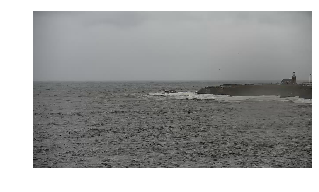

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f"{x.stem}{x.suffix}"

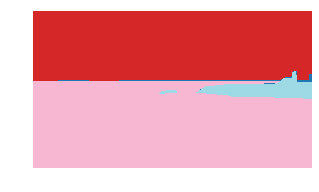

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 720, 1280]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]]))

In [12]:
codes = np.loadtxt(path/'codes_for_labelme.txt', dtype=str); codes

array(['__ignore__', '_background_', 'Sky', 'Ocean', 'Ground'], dtype='<U12')

In [13]:
size = src_size//2
bs=4

In [14]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

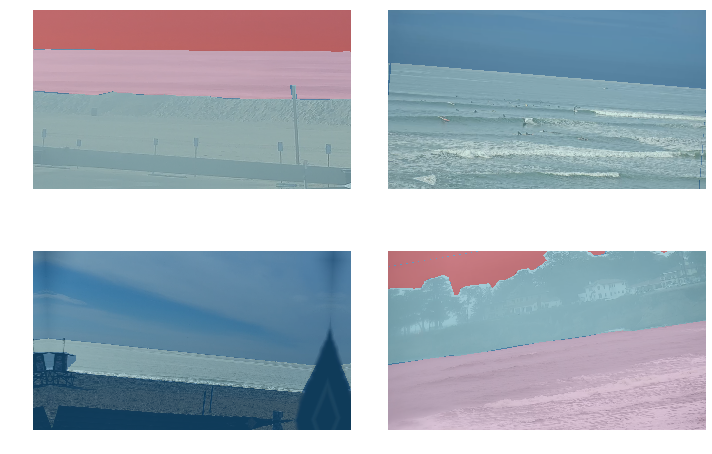

In [16]:
data.show_batch(2, figsize=(10,7))

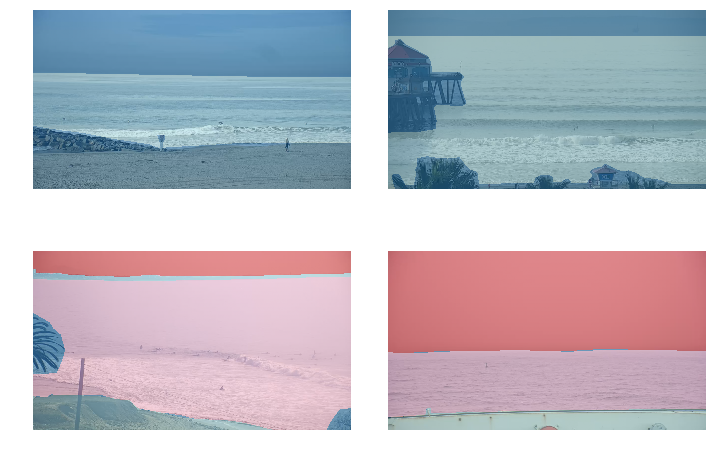

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [46]:
name2id = {v:k for k,v in enumerate(codes)}
ignore_code = name2id['__ignore__']

def acc_labelme(input, target):
    target = target.squeeze(1)
    mask = target != ignore_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [47]:
metrics=acc_labelme
# metrics=accuracy

In [38]:
wd=1e-2

In [48]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


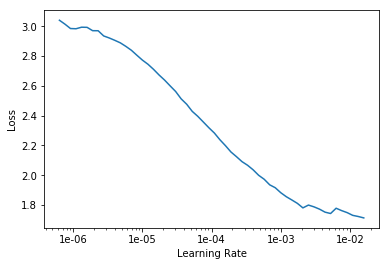

In [27]:
lr_find(learn)
learn.recorder.plot()

In [40]:
lr=3e-3

In [49]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_labelme,time
0,1.685658,1.812820,0.623265,00:14
1,1.479862,1.152761,0.690922,00:09
2,1.320368,1.063936,0.693436,00:09
3,1.222927,1.045108,0.713543,00:09
4,1.162576,0.929733,0.536193,00:09
5,1.126676,1.007749,0.799304,00:09
6,1.245763,1.810366,0.467328,00:09
7,1.273092,1.134855,0.545321,00:09
8,1.372132,1.171679,0.766327,00:09
9,1.343247,1.176359,0.676900,00:09


In [51]:
learn.save('stage-1-small-set')

In [52]:
learn.load('stage-1-small-set');

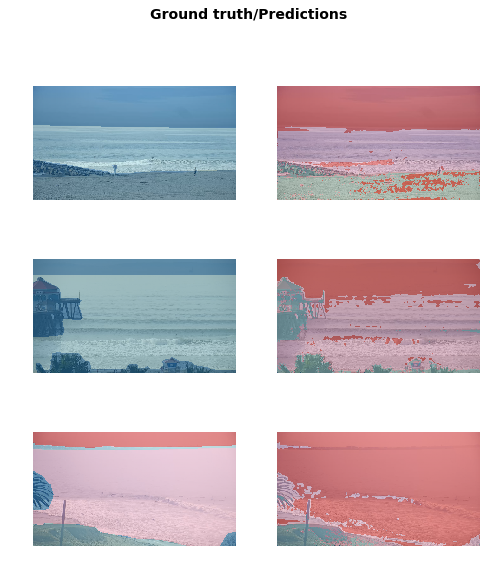

In [53]:
learn.show_results(rows=3, figsize=(8,9))